In [ ]:
# Download data files and images for this notebook
!wget https://github.com/goodchemistryco/Tangelo-Examples/raw/main/examples/img/umbrella_inversion_H3Op.png --quiet
!wget https://github.com/goodchemistryco/Tangelo-Examples/raw/main/examples/hardware_experiments/data/umbrella_inversion.zip --quiet
!unzip -qq umbrella_inversion.zip

In [ ]:
# Install Tangelo with pip, from the develop branch on Github
!pip install git+https://github.com/goodchemistryco/Tangelo.git@develop --quiet

# Install an optional simulator backend (ex: Qulacs)
!pip install qulacs --quiet

# Exploring the umbrella inversion with quantum computers

## Table of contents:
* [1 Introduction](#1)
* [2 The umbrella inversion](#2)
* [3 Reduce problem size with MI-FNO](#3)
* [3.1 Generate the MIFNO fragments](#31)
* [3.2 Import fragment data](#32)
* [4 Explore quantum workflows with Tangelo](#4)
* [4.1 ADAPT VQE circuit](#41)
* [4.2 Simulate the noisy quantum device](#42)
* [5.1 Preparing and running a quantum experiment on Amazon Braket](#51)
* [5.2 Construct classical shadow and purify](#52)
* [5.3 Energy resummation and plot](#53)
* [6 Bonus: Nuclear Dynamics Simulation](#60)

## 1 Introduction <a class="anchor" id="1"></a>

In this notebook we present an experimental study of the umbrella inversion on a quantum computer using [Tangelo](https://github.com/goodchemistryco/Tangelo), [Amazon Braket](https://aws.amazon.com/braket/), and [QEMIST Cloud](https://goodchemistry.com). A blog post about this study is available on [Amazon's Quantum Blog](url).

The umbrella inversion is a quantum effect related to tunnelling, that can be that can be observed in many organic molecules with a free electron pair residing on a trivalent atom. These include amines containing a nitrogen centre but it can also be observed in hydronium H$_3$O$^+$, in which the central atom is oxygen. We start our experiment setup by defining the hydronium molecule, and choosing a the chemical basis cc-pVDZ for our calculation.

In [3]:
atoms = """
O    -0.63100    1.21783    0.07611
H     0.34564    1.31652   -0.02093
H    -0.97483    1.78491    0.80631
H    -0.88121    0.27338    0.21147
"""

charge = 1
spin = 0
basis = "cc-pVDZ"

## 2 The umbrella inversion <a class="anchor" id="2"></a>

Let's illustrate the umbrella inversion using the hydronium molecule. We first define a function that can vary the molecular geometry as the positions of the hydrogen atoms change around the oxygen centre. This can be parameterized in terms of a single angle between the H-O bond and the molecule's main rotational axis. To simplify the problem, we assume the bond length does not depend on the angle, and is equal to 0.986$\overset{\circ}{A}$.

In [4]:
def H3O_angle(theta):
    d = 0.986
    theta = theta*np.pi/180
    C, S = np.cos(theta), np.sin(theta)
    c, s = np.cos(np.pi/3), np.sin(np.pi/3)
    H_pos = d*np.array([[   S,    0, C],
                        [-S*c,  S*s, C],
                        [-S*c, -S*s, C]])
    return [["O", (0.,0.,0.)], ["H", tuple(H_pos[0])], ["H", tuple(H_pos[1])], ["H", tuple(H_pos[2])]]

We calculate the energy of the molecule for a range of angles. Here, we limit ourselves to the Hartree-Fock solution. We build the system as a ``SecondQuantizedMolecule`` object, which automatically calculates the mean-field energy.

In [5]:
import numpy as np

from tangelo import SecondQuantizedMolecule

theta = np.linspace(60, 120, 31)
rhf = []

for t in theta:
    mol_theta = SecondQuantizedMolecule(H3O_angle(t), q=charge, spin=spin, basis=basis)
    rhf.append(mol_theta.mean_field.e_tot)

Plotting the results below we see the double well potential of the umbrella curve, showing two geometries with optimal ground state energies the system may tunnel between. This tunelling corresponds to the electron pair flipping from one side of the oxygen atom to the other - or equivalenty, the hydrogen atoms moving from one side to the other.

Text(0, 0.5, 'Energy [Ha]')

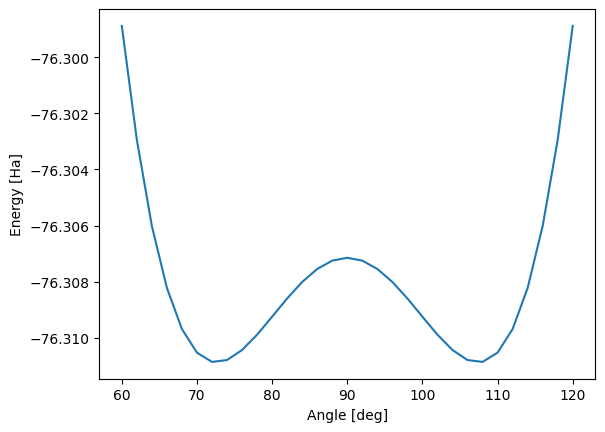

In [6]:
import pylab as plt

plt.plot(theta, rhf)
plt.xlabel("Angle [deg]")
plt.ylabel("Energy [Ha]")

## 3 Reduce problem size with MI-FNO <a class="anchor" id="3"></a>

Studying the umbrella inversion by tackling this chemical system head-on is well beyond the capabilities of current quantum computers. For instance, a straightforward approach using the Variational Quantum Eigensolver (VQE) algorithm with the UCCSD ansatz would yield circuits requiring over 50 qubits, millions of gates, and hundreds of thousands variational parameters. Numerical results would be drown in noise. In order to explore this problem with quantum computing, a more sophisticated workflow is necessary. 

This section describes how tools such as QEMIST Cloud and Tangelo can be combined to extend the range of chemical systems that can be explored with nascent quantum devices. The MI-FNO method available in QEMIST cloud can be employed to decompose the initial problem into a collection of smaller subproblems ("fragments"), whose resolution requires less computational resources. These approaches are also commonly referred to as "fragmentation" or "embedding" techniques.

For our quantum experiment, we attempt to solve one of these subproblems using a quantum workflow. We then analyze the results and assess the difference in total energy between our quantum experiment and the fully classical calculations.

In the first part, we show how to apply MI-FNO to the system of interest and compute classical reference values. We then show how to import them into Tangelo, to enable our quantum exploration.

## 3.1 Generate the MI-FNO fragments <a class="anchor" id="31"></a>


The following code excerpt illustrates how QEMIST Cloud users can perform a MI-FNO decomposition using our client library, and obtain reference results computed with our classical solvers.

Here we define a molecule object, and then our approach, based on combining the Heat-Bath Configuration interaction (HBCI) classical solver, the Method of Increments (MI) and the Frozen Natural Orbitals (FNO) method for the virtual space cutoff. We request an estimate of the cost of the simulation and then perform it.

To simplify this notebook, the results of this simulation have been precomputed and provided. The code snippets are available below, but were not designed to be run in this notebook as QEMIST Cloud is not yet publically available at the time of writing.

```python
import os
os.environ['QEMIST_PROJECT_ID'] = "your-project-ID"
os.environ['QEMIST_AUTH_TOKEN'] = "your-authentication-token"

from qemist_client.molecule import Molecule
from qemist_client.problem_decomposition import IncrementalDecomposition
from qemist_client.problem_reduction import FNO
from qemist_client.electronic_structure_solvers import HBCI
from qemist_client.util import get_results, check_problem_cost

qemist_mol = Molecule(atoms, basis=basis, charge=charge, spin=spin)

hbci_solver = HBCI()
fno = FNO(hbci_solver, export_fragment_data=True)
mi_solver = IncrementalDecomposition(electronic_structure_solver=fno, 
                                     truncation_order=3, 
                                     method_of_truncation_threshold=5e-3)

# Request a cost estimate of the simulation beforehand
cost = check_problem_cost(qemist_mol, mi_solver)

# Submit the problem to QEMIST Cloud
handle = mi_solver.simulate(system=qemist_mol)
```


The following code exports the fragment data resulting from the QEMIST Cloud simulation, later to be imported into Tangelo.

In [7]:
import json

path = "./data_H3O_ccpvdz_mifno_hbci/"
jfile = "H3O_CCPVDZ_MIFNO_HBCI.json"

```python
# Retrieve results using handle
qemist_res = get_results(handle)

# Export subproblem data to individual files
with open(path + jfile, "w") as f:
    json.dump(qemist_res, f)
    
for n_trunc, frags in qemist_res["subproblem_data"].items():
    for frag_id, frag in frags.items():
        prob_handle = frag["problem_handle"]

        if prob_handle:
            frag_res = get_results(prob_handle)

            with open(path + f"/{prob_handle}.json", "w") as f:
                json.dump(frag_res, f)
```

## 3.2 Import fragment data <a class="anchor" id="32"></a>

We import the data resulting from the simulation run by QEMIST Cloud into Tangelo and prepare the quantum experiment using the fragment data. The `MIFNOHelper` class provided by Tangelo handles most of the work.

Printing the resulting object displays reference energies computed by QEMIST Cloud, as well as the breakdown of the fragments and how they contribute to the energy the system. We find out that the initial problem was broken into:
- 4 1-body fragments
- 6 2-body fragments
- 4 3-body fragments

These subproblems contribute differently to the total energy of the system and their computational complexity vary. This information can guide us in selecting subproblems that are relevant to current quantum devices or quantum algorithms. 

This exploration is currently done manually, with the purpose of research in mind. As advances in quantum hardware and algorithms are made, automated scheduling and streamlined execution of relevant subproblems on quantum devices through QEMIST Cloud could become a reality.

In [8]:
from tangelo.problem_decomposition import MIFNOHelper

# Read the results from the json files
fno_fragments = MIFNOHelper(mi_json_file=path+jfile, fno_json_folder=path)
print(fno_fragments)

# Import MO coeffs
fno_fragments.retrieve_mo_coeff(path)

(All the energy values are in hartree)
Total MI-FNO energy = -76.52019103159677
Correlation energy = -0.2093647955082076
Mean-field energy = -76.31082623608856
            epsilon  energy_total  correction  energy_correlation
(1,)      -0.027343    -76.338169   -0.009120           -0.027343
(2,)      -0.027344    -76.338170   -0.009120           -0.027344
(3,)      -0.027344    -76.338170   -0.009120           -0.027344
(4,)      -0.017714    -76.328540   -0.017714           -0.017714
(1, 2)    -0.016601    -76.382115   -0.026852           -0.071288
(1, 3)    -0.016601    -76.382115   -0.026852           -0.071288
(1, 4)    -0.024389    -76.380272   -0.029541           -0.069446
(2, 3)    -0.016602    -76.382116   -0.026852           -0.071290
(2, 4)    -0.024390    -76.380274   -0.029541           -0.069448
(3, 4)    -0.024390    -76.380274   -0.029541           -0.069448
(1, 2, 3)  0.000446    -76.442216   -0.052484           -0.131389
(1, 2, 4)  0.004302    -76.444305   -0.057833   

We choose fragment `(2,)`, one of the one-body fragments listed above, as the focus of our quantum experiment. The code cell below constructs its Hamiltonian and maps it into qubit form using the scBK mapping. This yields a two-qubit problem which can be easily fitted on any quantum device. The Hamiltonian only involves X and Z Pauli operators, which means we only need to run simulations in a handful of measurement bases, as shown below.

You can try selecting a different fragment and see what qubit Hamiltonian comes out of it. For instance, some 3-body fragments yield Hamiltonians mapped to 12 qubits (10 if using scBK for the mapping).

In [9]:
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping

# Select fragment of interest.
selected_fragment = "(2,)"

frozen_orbitals = fno_fragments[selected_fragment]["frozen_orbitals_truncated"]
correction = fno_fragments[selected_fragment]["correction"]
e_tot_frag = fno_fragments[selected_fragment]["energy_total"]

# Create molecule object for fragment, and compute the molecular integrals.
mol = SecondQuantizedMolecule(atoms, q=charge, spin=spin, basis=basis, frozen_orbitals=frozen_orbitals)

# Selection of a fragment and computing the related FermionOperator.
ferm_op = fno_fragments.compute_fermionoperator(mol, selected_fragment)
ferm_op.n_electrons, ferm_op.n_spinorbitals = fno_fragments.n_electrons_spinorbs(selected_fragment)
ferm_op.spin = spin

# Map FermionOperator to QubitOperator.
n_electrons, n_spinorbitals = fno_fragments.n_electrons_spinorbs(selected_fragment)
qu_op = fermion_to_qubit_mapping(ferm_op, mapping="scbk", n_spinorbitals=n_spinorbitals, n_electrons=n_electrons)

print(qu_op)

-75.03707306024805 [] +
0.025894296540557086 [X0] +
0.21772992233328325 [X0 X1] +
0.025894165002379746 [X0 Z1] +
0.6466599564486686 [Z0] +
0.025894165002379746 [Z0 X1] +
0.0195667370570633 [Z0 Z1] +
0.02589429654055709 [X1] +
0.6466599564486686 [Z1]


## 4 Explore quantum workflows with Tangelo <a class="anchor" id="4"></a>

A number of quantum solvers are available in Tangelo. In order to design an interesting quantum experiment, we need to do some exploration and try to find an approach with reasonable compute requirements (number of qubits, number of gate operations, number of measurements, etc). This section first shows how we investigated an approach based on ADAPT-VQE using an exact simulator, and then attempted to account for the presence of noise for the target quantum device.

## 4.1 ADAPT VQE circuit <a class="anchor" id="41"></a>

Here we use the [ADAPT](https://doi.org/10.1038/s41467-019-10988-2) ansatz with a pool of operators defined using Qubit Coupled Cluster ([QCC](https://arxiv.org/pdf/1906.11192.pdf)) by constructing a Direct Inversion Set (DIS) from a qubit Hamiltonian. For our use case, this approach results in a shallow circuit that is within current quantum devices capabilities.

More algorithms are available in Tangelo, each supporting a number of built-in options and user customization: we invite you to explore them.

In [10]:
from tangelo.toolboxes.ansatz_generator._qubit_cc import construct_dis
from tangelo.toolboxes.ansatz_generator._qubit_mf import init_qmf_from_hf

def qcc_pool(mol: SecondQuantizedMolecule, mapping, up_then_down, qubit_hamiltonian):
    qmf_var_params = init_qmf_from_hf(mol.n_active_sos, mol.n_active_electrons, 
                                      mapping, up_then_down, mol.spin)
    dis = construct_dis(qubit_hamiltonian, qmf_var_params, 0.)
    dis_flat = [item for sublist in dis for item in sublist]
    return dis_flat

In [11]:
from tangelo.algorithms import ADAPTSolver

pool_args = {"mol": mol, "mapping": "scbk", "up_then_down": True, "qubit_hamiltonian": qu_op}
opt_dict = {"qubit_hamiltonian": qu_op, "tol": 0.01, "max_cycles": 5,
            "qubit_mapping": "scbk", "n_spinorbitals": n_spinorbitals, "n_electrons": n_electrons, 
            "spin": spin, "pool": qcc_pool, "pool_args": pool_args}

adapt_solver = ADAPTSolver(opt_dict)
adapt_solver.build()
adapt_solver.simulate()

adapt_circ = adapt_solver.vqe_solver.optimal_circuit

/usr/local/lib/python3.9/dist-packages/tangelo/toolboxes/qubit_mappings/statevector_mapping.py:149: RuntimeWarning: Symmetry-conserving Bravyi-Kitaev enforces all spin-up followed by all spin-down ordering.
  warnings.warn("Symmetry-conserving Bravyi-Kitaev enforces all spin-up followed by all spin-down ordering.", RuntimeWarning)


A quick look at the ADAPT circuit resulting from the code above. It is shallow enough for the current quantum devices.

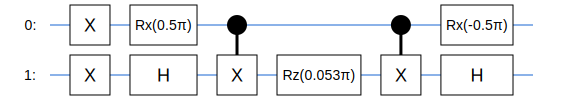

In [12]:
adapt_circ.draw()

## 4.2 Optional: Simulate the noisy quantum device  <a class="anchor" id="42"></a>

We can run the circuit on a noisy simulator and recompute the fragment energy to get some idea of what to expect before we commit to running a full experiment, which costs money and time.

Below we define a noise model based on specifications of the IonQ Harmony device, which is the machine we considered for running our experiment. The data used came from the Amazon Braket device page, during summer 2022.

In [13]:
from tangelo.linq.noisy_simulation import NoiseModel

# Define 1- and 2-qubit gate error  (Based on Braket dashboard)
n1q = 1 - 0.9953
n2q = 1 - 0.9394

# Build a simple depolarization model using the gates in our circuit
nmd = NoiseModel()
nmd.add_quantum_error("CNOT", "depol", n2q)
for gate in ["RX", "RZ", "X", "H"]:
    nmd.add_quantum_error(gate, "depol", n1q)

As with quantum hardware, we need to append the circuit with measurement basis gates before submitting them to a device or simulator. In the case of the selected 1-body fragment, we would need to acquire measurements in the four bases specified below, as the terms in the Hamiltonian only commute with these.

In [14]:
from tangelo.linq import Circuit
from tangelo.linq.helpers.circuits import measurement_basis_gates, pauli_string_to_of

circs = []
basis_list = ["ZZ", "XZ", "ZX", "XX"]

for b in basis_list:
    c = adapt_circ.copy()
    c += Circuit(measurement_basis_gates(pauli_string_to_of(b)))
    circs.append(c)

We perform a noisy simulation of the four circuits and obtain the corresponding frequency histograms, here using Cirq as a backend.

In [15]:
from tangelo.linq import get_backend

sim = get_backend("cirq", n_shots=10**6, noise_model=nmd)
hists = [sim.simulate(c)[0] for c in circs]

We can then use them to compute the expectation value for the energy of the fragment. We employ histogram aggregation to use all available data for the terms that can be computed from more than one measurement basis. The ``Histogram`` class facilitates these steps.

In [16]:
from tangelo.toolboxes.post_processing.histogram import Histogram, aggregate_histograms
from tangelo.linq.helpers.circuits import pauli_of_to_string, get_compatible_bases

hist_dict = {b: Histogram(h, 10**6) for b,h in zip(basis_list, hists)}
en = 0.

for t,c in qu_op.terms.items():
    p = pauli_of_to_string(t,2)
    bl = get_compatible_bases(p, basis_list)
    en += aggregate_histograms(*[hist_dict[b] for b in bl]).get_expectation_value(t,c)

print("MI-FNO energy:     ", e_tot_frag)
print("Aggregated energy: ", en + correction)

MI-FNO energy:      -76.33817036745623
Aggregated energy:  -76.16544280598923


We can use the computed fragment energy to recalculate the full system energy to get an idea of the impact on overall total energy:

In [17]:
# Energy resummation
e_mifno = fno_fragments.e_tot
e_sim= fno_fragments.mi_summation({"(2,)": en})

print("MI-FNO energy:     ", e_mifno)
print("Simulated energy: ", e_sim)

MI-FNO energy:      -76.52019103159677
Simulated energy:  -76.34746347012977


We see that the energy simulated using the noise level obtained from the characterization of the IonQ Harmony device differs significantly from the MI-FNO energy. This motivates us to introduce some error mitigation techniques in order to correct for the hardware noise.

# 5 Designing and running a quantum experiment

One of the more flexible approaches to estimating eigenvalues from a quantum state is the [classical shadow protocol](https://arxiv.org/abs/1711.01053). By performing measurements for a randomized set of Pauli operator tensor products we can recreate a classical "snapshot" of the quantum state, which can be used to calculate expectation values of observables or construct a density matrix. Tangelo provides us with tools to construct and operate with classical shadows.

The second mitigation strategy we employ is symmetry post-selection. The idea is to apply a symmetry operator corresponding to a Pauli word that commutes with the Hamiltonian and entangle the system with an ancilla acting as a symmetry verification qubit. We then select only the samples that are associated with the correct symmetry eigenvalue: the other samples are discarded.



In this experiment, we examine how well these two techniques perform, separately and together. We apply this approach using a $ZZ$ symmetry operator and construct a randomized classical shadow, which is necessary to reconstruct the reduced density matrices required to post-process the results. As illustrated in the cell below, applying this approach to our ADAPT circuit would entangle our 2 qubits with an additional ancilla qubit.

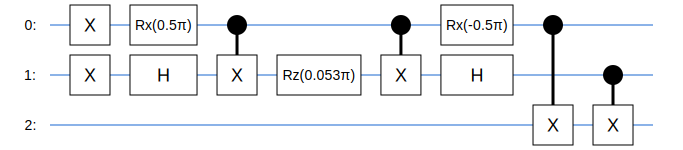

In [18]:
from tangelo.toolboxes.post_processing import ancilla_symmetry_circuit

adapt_symmpostselect_circ = ancilla_symmetry_circuit(adapt_circ, "ZZ")
adapt_symmpostselect_circ.draw()

## 5.1 Running on Amazon Braket <a class="anchor" id="51"></a>

Tangelo provides tools to construct a randomized shadow. For simplicity here, since for a two qubit system there are very few measurement bases, we excplitly specify them to expose more clearly how we use Braket. We define all the possible measurement bases below, and for each of these we append first the symmetry verification circuit and then transform the system qubits into the corresponding measurement basis. QEMIST Cloud users can leverage the Tangelo integration to submit the experiments to Amazon Braket, as shown below. Since QEMIST Cloud is not yet publically available, we simply provide the code snippets and their outputs.

In [19]:
n_shots = 10**5

# All 2-qubit measurement bases needed for the classical shadow
cs_basis_list = ["ZZ", "XZ", "ZX", "XX", "YZ", "ZY", "YY", "XY", "YX"]

```python
from tangelo.linq.qpu_connection import QEMISTCloudConnection

qemcl = QEMISTCloudConnection()
qemcl.job_estimate(adapt_circ, n_shots)
```

The code cell above returns the prices for running 10,000 shots of the circuit provided, on the supported quantum devices and simulators, here part of Amazon Braket's selection. Here's the output from back then:

```text
{'arn:aws:braket:::device/qpu/ionq/ionQdevice': 100.3,
 'arn:aws:braket:::device/quantum-simulator/amazon/sv1': 0.038,
 'arn:aws:braket:us-west-1::device/qpu/rigetti/Aspen-M-1': 3.8}
```

The code below adds the symmetry post-selection gates and the measurement gates to define our quantum circuit for each of the measurement bases, and submits them to Braket, using their QEMIST Cloud credits.
It is however possible for Braket users to submit these jobs using the Braket API or our convenience wrappers, with their own Braket credentials.

We submit overall 9 quantum circuits, differing by their final measurement gates.

```python
backend = 'arn:aws:braket:::device/qpu/ionq/ionQdevice'

job_ids = {}

# Build circuits and submit to Amazon Braket
for basis in cs_basis_list:
    meas_circ = Circuit(measurement_basis_gates(pauli_string_to_of(basis)))
    final_circ = adapt_symmpostselect_circ + meas_circ

    job_id = qemcl.job_submit(final_circ, n_shots=n_shots, backend=backend)
    job_ids[basis] = job_id

# Retrieve results and save to json file
res = {basis: qemcl.job_result(job_id)[0] for basis, job_id in job_ids.items()}

with open("./ionq_data/H3Op_sym_postselect_10000_ionq.json", "w") as file:
    json.dump(res, file)
```

Replacing job submission by cost estimation in the code above is a way to assess the total cost of the experiment before submitting anything. As experiments are usually done on a budget, this information is still rather central in its design. Here we'd get an estimate of about $900.

Below we read in the data that we obtained from our experiment on IonQ Harmony during the Summer of 2022, and perform full symmetry post-selection.

In [20]:
# Load the data coming from our quantum experiment on Harmony
with open("./ionq_data/H3Op_sym_postselect_10000_ionq.json", "r") as file:
    res = json.load(file)

# Perform post-selection
res_post = {}
for base, hist in res.items():
    h = Histogram(hist)
    h.post_select({2: "0"})
    res_post[base] = h

print(res_post)

{'ZZ': {'00': 0.0087, '01': 0.0056, '10': 0.0053, '11': 0.9136}, 'XZ': {'00': 0.0101, '01': 0.5165, '10': 0.0051, '11': 0.4167}, 'ZX': {'00': 0.0049, '01': 0.0103, '10': 0.4553, '11': 0.4728}, 'XX': {'00': 0.1809, '01': 0.2659, '10': 0.2629, '11': 0.2281}, 'YZ': {'00': 0.0051, '01': 0.5002, '10': 0.0104, '11': 0.4106}, 'ZY': {'00': 0.0033, '01': 0.0101, '10': 0.4859, '11': 0.4321}, 'YY': {'00': 0.2659, '01': 0.185, '10': 0.2278, '11': 0.2549}, 'XY': {'00': 0.1904, '01': 0.1958, '10': 0.2416, '11': 0.2919}, 'YX': {'00': 0.2233, '01': 0.2413, '10': 0.221, '11': 0.2388}}


## 5.2 Post-processing: construct classical shadow and purify <a class="anchor" id="52"></a>

We can now construct a classical shadow and purify the state.

In [21]:
from tangelo.toolboxes.measurements import RandomizedClassicalShadow

bitstrings, unitaries = [], []
    
for b, hist in res_post.items():
    for s,f in hist.frequencies.items():
        factor = round(f*(n_shots))
        bitstrings.extend([s]*factor)
        unitaries.extend([b]*factor)

ionq_cs_post = RandomizedClassicalShadow(unitaries=unitaries, bitstrings=bitstrings)

After constructing the shadow, we can use convenience functions provided by Tangelo to compute the 1- and 2-RDM. Since this is a small, two qubit system, we can use the McWeeny technique to purify the 2-RDM and calculate the purified energy. Below we show a comparison of the difference between the purified and non-purified energies and suggests that purification mitigates the noise efficiently.

In [22]:
from tangelo.toolboxes.post_processing.mc_weeny_rdm_purification import mcweeny_purify_2rdm
from tangelo.toolboxes.molecular_computation.rdms import compute_rdms, energy_from_rdms

rdm1_p, rdm2_p, rdm1_ss_p, rdm2_ss_p = compute_rdms(ferm_op, "scbk", True, exp_data=res)
rdm1_p_pur, rdm2_p_pur = mcweeny_purify_2rdm(rdm2_p.real)

In [23]:
e_p_exp = energy_from_rdms(ferm_op, rdm1_ss_p, rdm2_ss_p)
e_p_pur = energy_from_rdms(ferm_op, rdm1_p_pur, rdm2_p_pur)

print("Experiment energy:", e_p_exp)
print("Purified energy:  ", e_p_pur)
print("Diff from MI-FNO:   ", e_p_pur-(e_tot_frag-correction))

Experiment energy: -76.2369464417231
Purified energy:   -76.3276400895683
Diff from MI-FNO:    0.001410481713961076


A similar calculation can be performed for non-post-selected data, which one can obtain by removing the ancilla qubit and adding together the corresponding frequencies. This data can also be purified to see the effect of the two mitigation techniques separately. For brevity, we present the final results:

In [24]:
e_exp = -76.2685
e_pur = -76.3138

Finally, we can estimate the error of the energy by using a technique called bootstrapping. This consists in generating an ensemble of new histograms by resampling from the experimental data and calculating a standard devition of the resulting energies. For brevity, here we only present the results of those calculations. You can find more details about bootstrapping in [this notebook](https://github.com/goodchemistryco/Tangelo/blob/develop/examples/overview_endtoend.ipynb).

In [25]:
e_exp_err = 0.0037
e_pur_err = 0.0019
e_p_exp_err = 0.0037
e_p_pur_err = 0.0007

## 5.3 Energy resummation and plot <a class="anchor" id="53"></a>

Finally, we need to recalculate the energy of the full system using this fragment energy to see the final result. We plot the whole data set, including the Hartree-Fock and MI-FNO umbrella curve, and the four total energies calculated below. In the inset we show the lower portion of the whole plot to emphasize the impact of the error mitigation techniques. The shaded region around the curve indicates the regime of chemical accuracy.

In [26]:
# Recompute total energy, overriding the fragment enregy with the different experimental results 
et_exp = fno_fragments.mi_summation({"(2,)": e_exp})
et_pur = fno_fragments.mi_summation({"(2,)": e_pur})
et_post_exp = fno_fragments.mi_summation({"(2,)": e_p_exp})
et_post_pur = fno_fragments.mi_summation({"(2,)": e_p_pur})

print("Classical:", fno_fragments.e_tot)
print("Raw:", et_exp)
print("Raw purified:", et_pur)
print("Post-selected:", et_post_exp)
print("Post-selected purified:", et_post_pur)

Classical: -76.52019103159677
Raw: -76.4596404603145
Raw purified: -76.5049404603145
Post-selected: -76.4280869020376
Post-selected purified: -76.5187805498828


We load the MI-FNO data precomputed with QEMIST Cloud for various geometries of the system of interest, in order to better illustrate where the results sit compared to Hartree-Fock and the MI-FNO resolution.

In [27]:
mifno_curve = np.loadtxt("H3Oplus_MIFNO_CCPVDZ.csv", delimiter=",")[:,1:].T

<ErrorbarContainer object of 3 artists>

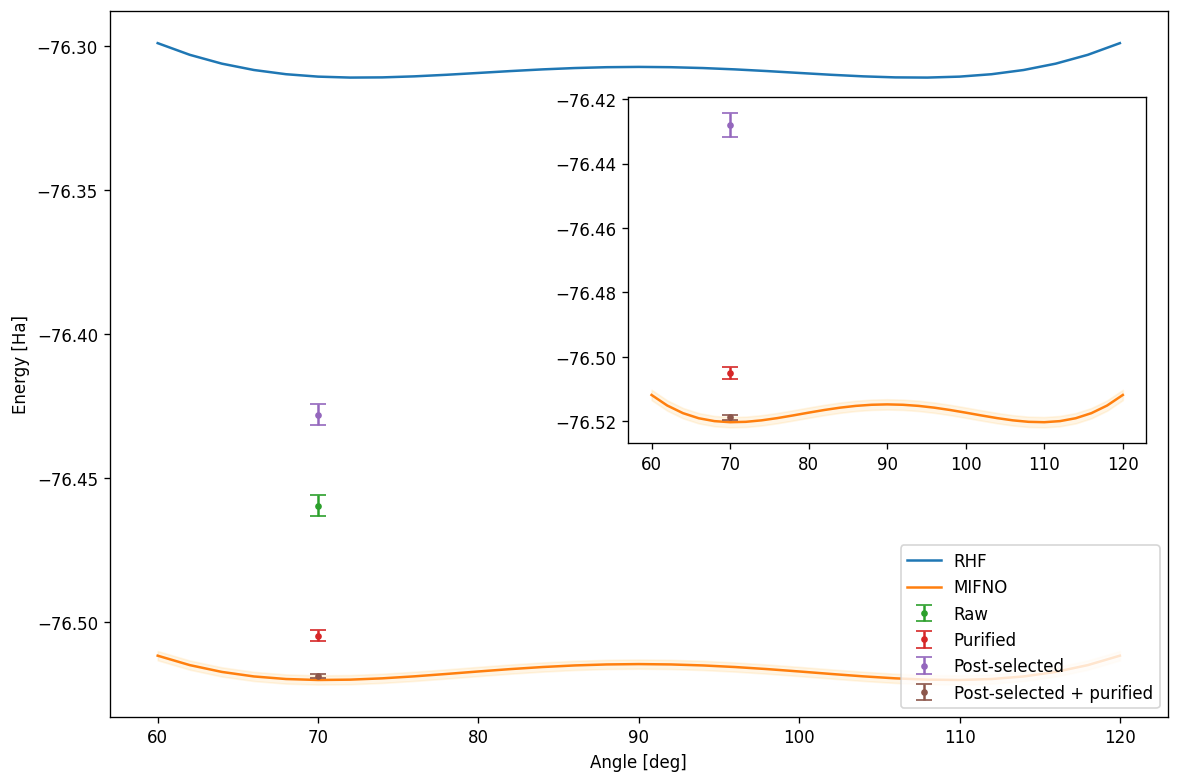

In [28]:
import pylab as plt

fig = plt.figure(figsize=(9,6), dpi=120)
ax = plt.axes([0.02,0.02,0.98,0.98])

ax.plot(theta, rhf, label="RHF")

ax.plot(mifno_curve[0], mifno_curve[1], label="MIFNO")
ax.fill_between(mifno_curve[0], mifno_curve[1]-0.0016, mifno_curve[1]+0.0016, color='orange', alpha=.1)

ax.errorbar(70, et_exp, e_exp_err, fmt=".", label="Raw", capsize=5)
ax.errorbar(70, et_pur, e_pur_err, fmt=".", label="Purified", capsize=5)
ax.errorbar(70, et_post_exp, e_p_exp_err, fmt=".", label="Post-selected", capsize=5)
ax.errorbar(70, et_post_pur, e_p_pur_err, fmt=".", label="Post-selected + purified", capsize=5)

ax.legend(loc="lower right")
ax.set_ylabel("Energy [Ha]")
ax.set_xlabel("Angle [deg]")

ax2 = plt.axes([0.5,0.4,0.48,0.48])
ax2.plot([],[])
ax2.plot(mifno_curve[0], mifno_curve[1], label="MIFNO")
ax2.fill_between(mifno_curve[0], mifno_curve[1]-0.0016, mifno_curve[1]+0.0016, color='orange', alpha=.1)

ax2.plot([],[])
ax2.errorbar(70, et_pur, e_pur_err, fmt=".", label="Purified", capsize=5)
ax2.errorbar(70, et_post_exp, e_p_exp_err, fmt=".", label="Post-selected", capsize=5)
ax2.errorbar(70, et_post_pur, e_p_pur_err, fmt=".", label="Post-selected + purified", capsize=5)

## 6 Bonus: Nuclear Dynamics Simulation <a class="anchor" id="60"></a>

To examine the umbrella inversion in action, we can perform a quantum simulation of the nuclear motion. This is not possible on current quantum devices: we run the following fault-tolerant approach on a simulator.

We start with calculating the coordinate change in mass-weighted coordinates.

In [29]:
# Define constants for unit conversion, and hydrogen / oxygen atom mass
angstrom2bohr = 1.8897259886
me2amu = 1822.888486209
hm = 1.00784 * me2amu
om = 15.999 * me2amu

# Reduced mass for simulation
m = 3*hm*om/(3*hm+om)/me2amu

# OH bond length
d = 0.986 * angstrom2bohr

def calc_mw_coords(theta):
    """Calculate mass-weighted cartesian coordinates"""
    theta = theta*np.pi/180
    C, S = np.cos(theta), np.sin(theta)
    c, s = np.cos(np.pi/3), np.sin(np.pi/3)
    h_pos = d*np.array([[   S,    0, C],
                        [-S*c,  S*s, C],
                        [-S*c, -S*s, C]])
    o_pos = np.zeros(3)
    cmass = (hm*h_pos[0] + hm*h_pos[1] + hm*h_pos[2])/(3*hm+om)
    mw_coords = np.zeros((4,3), dtype=float)
    for i in range(3):
        mw_coords[i] = (h_pos[i] - cmass)*np.sqrt(hm)  
    mw_coords[3] = (o_pos-cmass)*np.sqrt(om)  
    return mw_coords

# Reference configuration 
# (Case where all atoms of H3O+ are on the same plane)
ref_config = calc_mw_coords(theta=90)

def calc_qs(theta, ref_config):
    """Return displacement in mass-weighted coordinates"""
    new_config = calc_mw_coords(theta)
    diff = 0
    for i in range(4):
        diff += np.dot(ref_config[i] - new_config[i], ref_config[i] - new_config[i])
    return np.sqrt(diff)

thetas = np.linspace(60, 120, 31)
mass_weighted = np.zeros(31)

for i, theta in enumerate(thetas):
    mass_weighted[i] = calc_qs(theta, ref_config)

# Only returns absolute value of displacement so need to assign negative value 
# to one direction
mass_weighted[:16] *= -1

Calculate interpolation of data for any coordinate length to use for nuclear dynamics.

In [30]:
from scipy.interpolate import CubicSpline

spl = CubicSpline(mass_weighted, mifno_curve[1])

# Use 8 qubits, corresponding to 64 grid pts for simulation
n_qubits = 8
n_pts = 2**n_qubits
xdata = np.linspace(-114.75, 114.75, n_pts, endpoint=True)
dx = xdata[1] - xdata[0]
interpolated_curve = spl(xdata)

We convert the interpolated data into an equivalent `QubitOperator` object.

In [31]:
import math
from itertools import product

from openfermion import get_sparse_operator
from scipy.sparse import diags

from tangelo.toolboxes.operators import QubitOperator

def qu_vpot(vals, order='lsq_first'):
    "Return representation of diagonal matrix as a QubitOperator where vals are the diagonal elements of the matrix."
    n_qubits=round(math.log2(len(vals)))
    new_vals = vals.copy()
    if order == "msq_first":
        new_vals = new_vals.reshape([2]*n_qubits).transpose(list(reversed(range(n_qubits)))).flatten() 
    v_op = QubitOperator()
    for i in product(["I", "Z"], repeat=n_qubits):
        tup = tuple([(j, op) for j, op in enumerate(i) if op != "I"])
        qu_op = QubitOperator(tup)
        v = get_sparse_operator(qu_op, n_qubits=n_qubits)
        v_op += (diags(new_vals).dot(v)).trace()*QubitOperator(tup)
    v_op /= 2**n_qubits
    return v_op   

# Choose qubit order so bitstrings are directly converted to data
qubit_order = "lsq_first" 
qu_op_v = qu_vpot(interpolated_curve, qubit_order)

We initialize the wavefunction to the gaussian $\sqrt{\frac{2}{\sigma \sqrt{2\pi}}}e^{-\left(\frac{x-x0}{\sigma}\right)^2}$ in left configuration, with $\sigma$ as the normalization factor.

In [32]:
from tangelo.linq.helpers.circuits.statevector import StateVector

sigma = 10
x0 = -50
init_vec = np.sqrt(2/sigma/np.sqrt(2*np.pi)) * np.exp(-((xdata - x0)/sigma)**2)*np.sqrt(dx)
initial_density = init_vec**2

state = StateVector(init_vec, order=qubit_order)
init_circuit = state.initializing_circuit()

We use the split operator method $e^{-i H \Delta t}\approx e^{-i p^2/2/m \Delta t}e^{-i v \Delta t}e^{-i p^2/2/m \Delta t}$. The kinetic energy term is calculated using the centered fast fourier transform for which the circuit can easily be generated using `get_psquared_circuit`. The potential evolution can be generated by calling `trotterize`. We run the simulation for about 1.2 ps.

In [33]:
from tangelo.linq import get_backend
from tangelo.toolboxes.circuits.grid_circuits import get_psquared_circuit
from tangelo.toolboxes.ansatz_generator.ansatz_utils import trotterize

# Specify qubit order to define psquared circuit (depends on statevector ordering)
qubit_list = list(reversed(range(n_qubits))) 

# Build split operator with n_trotter_steps
def trotter_func(n_trotter_steps, time):
    p2_circ = get_psquared_circuit(time/n_trotter_steps/2, dx=dx, mass=m, qubit_list=qubit_list)
    vcirc = trotterize(operator=qu_op_v, time=time/n_trotter_steps, n_trotter_steps=1)
    return (p2_circ + vcirc + p2_circ) * n_trotter_steps

# Time evolution for about 1.2 picoseconds
time = 50000
sim = get_backend()
f, _ = sim.simulate(init_circuit + trotter_func(200, time))

final_density = np.zeros(n_pts)
for key, prob in f.items():
    final_density[int(key, base=2)] = prob

Now let's plot the initial and final densities, as well as our interpolated curve.

(-0.05, 0.08)

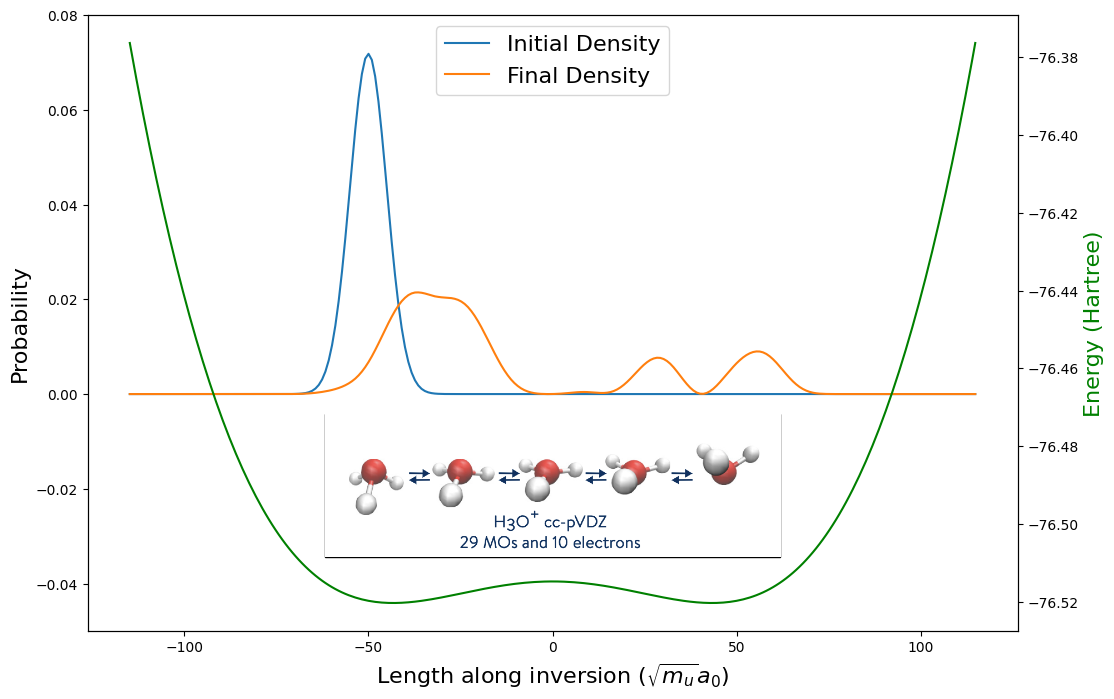

In [34]:
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import matplotlib.pyplot as plt

# Overlay H3O+ molecule image
file = "umbrella_inversion_H3Op.png"
inversion = image.imread(file)
imagebox = OffsetImage(inversion, zoom=0.4)
ab = AnnotationBbox(imagebox, (0, -76.49), pad=0)

fig, ax = plt.subplots(figsize = (12, 8))

# Main plot
ax2 = ax.twinx()
ax2.add_artist(ab)
ax.plot(xdata, initial_density, xdata, final_density)
ax2.plot(xdata, interpolated_curve, 'g-')
ax.set_xlabel("Length along inversion $(\sqrt{m_u} a_0)$", fontsize=16)
ax.set_ylabel("Probability", fontsize=16)
ax2.set_ylabel("Energy (Hartree)", color='g', fontsize=16)
ax.legend(["Initial Density", "Final Density"], fontsize=16, loc="upper center")
ax.set_ylim([-0.05, 0.08])

 In the figure, we see the initial density is localized in the left well signifying that the orientation of the molecule has the three hydrogen atoms below the oxygen nuclei (as depicted on the left side of the inset inversion process figure). The final density on the other hand shows peaks in the right well, which means that there is significant probability that the hydrogen atoms are localized above the oxygen atom. Even though the initial wave packet was localized below the barrier height, the wave packet tunneled through such that we have successfully witnessed the umbrella inversion!

## Closing words

This notebook illustrates how Tangelo, QEMIST Cloud and Amazon Braket can be combined to explore the potential of quantum computing for chemistry simulation, here using the umbrella inversion as a use case. It accompanies an article published on AWS Quantum blog, which goes more into detail about the chemistry and the experimental results obtained on a quantum device.

By breaking down a problem instance into a collection of subproblems requiring a lower amount of computational resources, the problem decomposition techniques available in Tangelo and QEMIST Cloud can extend the range of use-cases within reach of current quantum devices. The toolboxes in Tangelo support researchers at every step of their quantum exploration, by providing algorithms or reusable building-blocks to express their own custom workflows and put their ideas to the test.

What will you do with Tangelo ?